In [1]:
import h5py    
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif

In [2]:
path = ''
feature_path = './feature_selection_models/'

In [3]:
filename = path + 'N-CMAPSS_DS03-012.h5'

In [4]:
with h5py.File(filename, 'r') as hdf:
        
    X_columns = np.array(hdf.get(f'X_s_dev')).shape[1]
    
    X_train = pd.concat([pd.DataFrame(np.array(hdf.get(f'W_dev')), columns=np.array(hdf.get('W_var')).astype('U')),
                pd.DataFrame(np.array(hdf.get('X_s_dev')), columns=np.array(hdf.get('X_s_var')).astype('U'))], axis=1)
    X_train.rename(columns={'alt':'Altitude'}, inplace=True)
    
    Xw_columns = X_train.shape[1]
    
    aux_train = pd.concat([pd.DataFrame(np.array(hdf.get('Y_dev')), columns=['RUL']),
                pd.DataFrame(np.array(hdf.get('A_dev')), columns=np.array(hdf.get('A_var')).astype('U')).astype('int64')], axis=1)          

    aux_train.rename(columns={'unit':'Unit','cycle':'Cycle','Fc':'Class','hs':'State'}, inplace=True)
    
    aux_columns = aux_train.shape[1]
            

In [5]:
# For state 14 features, for RUL 18 features
X_state = X_train.iloc[:, -X_columns:]
y_state = aux_train['State']

# For RUL
train = pd.concat([aux_train, X_train], axis=1)
train = train[train['State'] == 0]


del X_train, aux_train

In [6]:
try:
    fs_f = joblib.load(feature_path + 'state_anova_model.pkl')
except:
    fs_f = f_classif(X_state, y_state)
    joblib.dump(fs_f, feature_path + 'state_anova_model.pkl') 

In [7]:
f_values = fs_f[0]
p_values = fs_f[1]

In [8]:
print(f'The relevant features are {len([p_value for p_value in p_values.tolist() if p_value < 0.001])}')

The relevant features are 14


In [9]:
pd.DataFrame(np.array([p_values]), columns=X_state.columns, index=['p_value'])

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf
p_value,0.0,1.693583e-240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


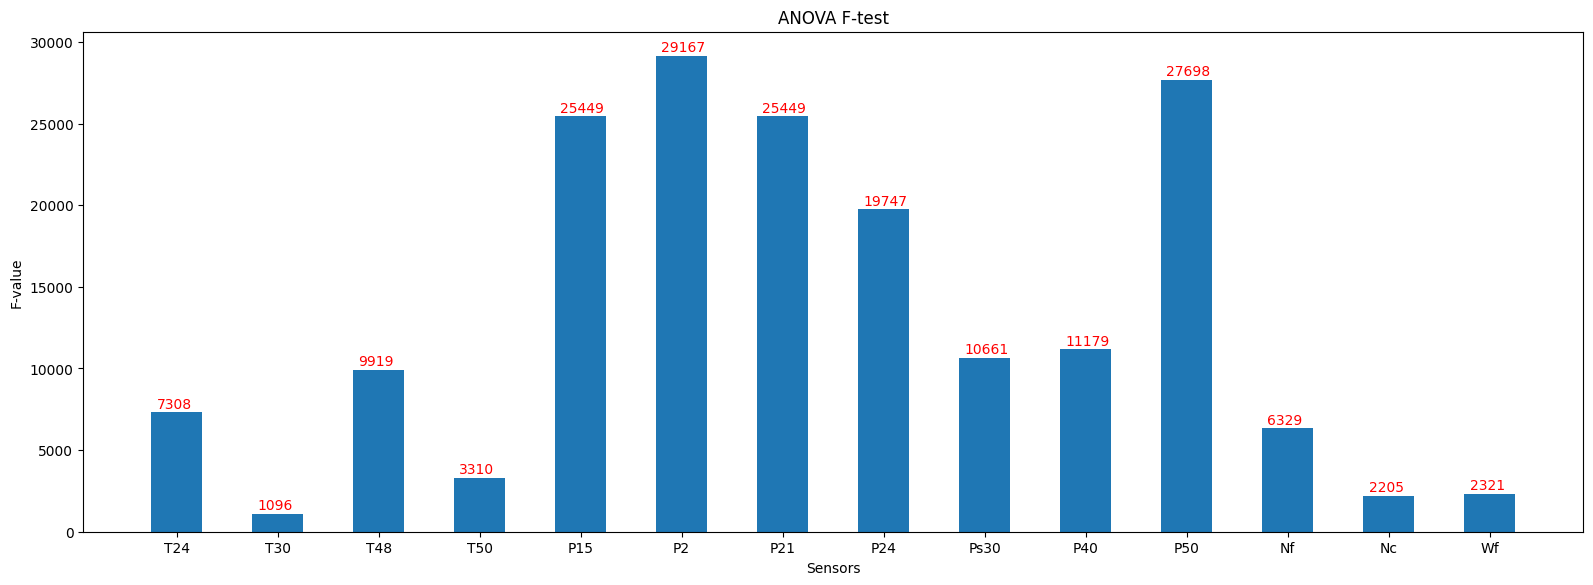

In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(X_state.columns, f_values, width=0.5)
for i, v in enumerate(f_values):
    ax.text(i - 0.2, v + 250, str(v.astype(int)), color='red')
plt.xlabel('Sensors')
plt.ylabel('F-value')
#plt.grid(linewidth=0.5)
plt.title('ANOVA F-test') 
plt.show()

In [11]:
try:
    mi_scores = joblib.load(feature_path + 'state_mutual_info_model.pkl')
except:
    mi_scores = mutual_info_classif(X_state, y_state)
    joblib.dump(mi_scores, feature_path + 'state_mutual_info_model.pkl')

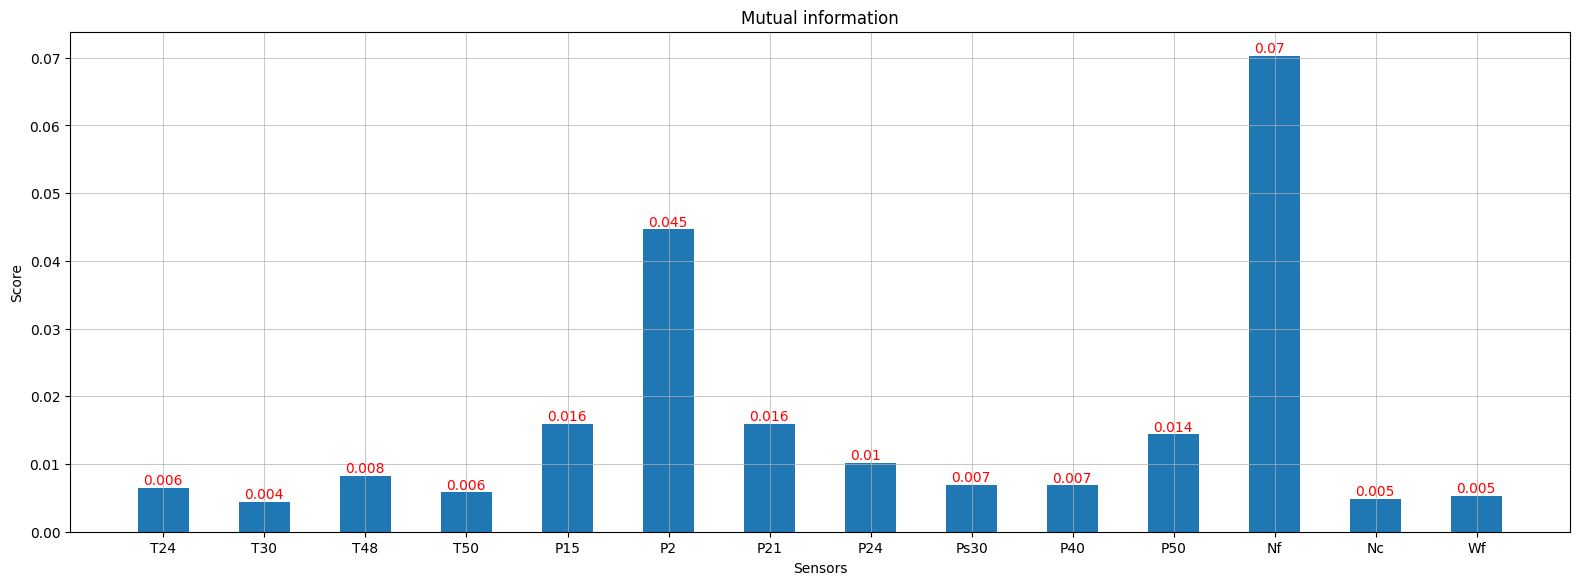

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(X_state.columns, mi_scores, width=0.5)
for i, v in enumerate(mi_scores):
    ax.text(i - 0.2, v + 0.0005 , str(v.round(3)), color='red')
plt.xlabel('Sensors')
plt.ylabel('Score')
plt.grid(linewidth=0.5)
plt.title('Mutual information') 
plt.show()

In [13]:
del X_state, y_state

In [14]:
# 0: 0-29, 1: 15-29, 2: >= 30
ruls_inf = [30, 15, 0]
classes = [2, 1, 0]


for idx, unit in enumerate(list(train['Unit'].unique()), start=1):
    
    print(f"\nUNIT {idx} of {len(train['Unit'].unique())}: N. {unit} \nCYCLE of {train[train['Unit'] == unit]['Cycle'].unique()[-1]}: ", end = ' ')
    
    # Index for starting RUL value
    c_idx = -1
    
    for cycle in list(train[train['Unit'] == unit]['Cycle'].unique()):
        
        print(cycle, end = ' ')
        
        rul = train[(train['Unit'] == unit) & (train['Cycle'] == cycle)]['RUL'].iloc[0]

        # Find new starting RUL c_idx
        if c_idx == -1:
            for c_idx, value in enumerate(ruls_inf):             
                if value <= rul:
                    break

        train.loc[(train['Unit'] == unit) & (train['Cycle'] == cycle), 'RUL'] = classes[c_idx]

        if (rul == ruls_inf[c_idx]):
            c_idx += 1


UNIT 1 of 9: N. 1 
CYCLE of 72:  37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 
UNIT 2 of 9: N. 2 
CYCLE of 73:  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 
UNIT 3 of 9: N. 3 
CYCLE of 67:  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 
UNIT 4 of 9: N. 4 
CYCLE of 60:  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
UNIT 5 of 9: N. 5 
CYCLE of 93:  38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 
UNIT 6 of 9: N. 6 
CYCLE of 63:  18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 6

In [15]:
X_rul = train.iloc[:, -Xw_columns:]
y_rul = train.loc[:, 'RUL']

del train

RUL
2      1378059
0      1189711
1      1154236
Name: count, dtype: int64

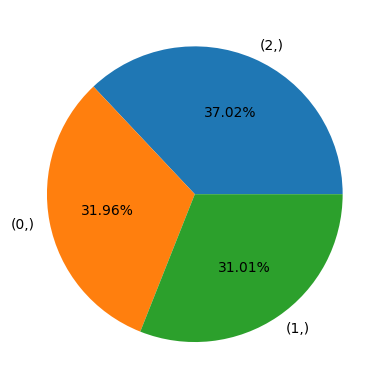

In [16]:
plot = pd.DataFrame(y_rul, dtype='int64').value_counts().plot.pie(autopct='%.2f%%', label='')
pd.DataFrame(y_rul, columns = ['RUL'], dtype='int64').value_counts()

In [17]:
try:
    fs_f = joblib.load(feature_path + 'rul_anova_model.pkl')
except:
    fs_f = f_classif(X_rul, y_rul)
    joblib.dump(fs_f, feature_path + 'rul_anova_model.pkl') 

In [18]:
f_values = fs_f[0]
p_values = fs_f[1]

In [19]:
print(f'The relevant features are {len([p_value for p_value in p_values.tolist() if p_value < 0.001])}')

The relevant features are 18


In [20]:
pd.DataFrame(np.array([p_values]), columns=X_rul.columns, index=['p_value'])

,Altitude,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf
p_value,0.0,3.801448e-20,3.766045e-36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.601083e-23,0.0,0.0


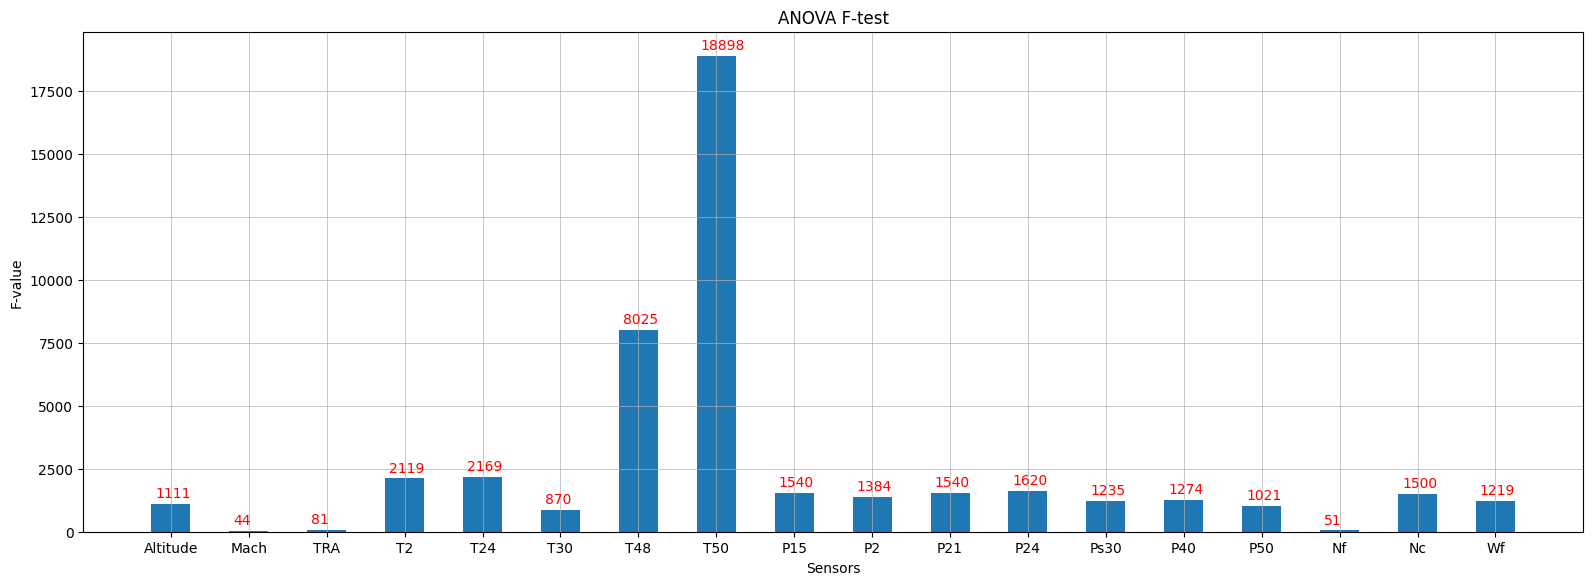

In [21]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(X_rul.columns, f_values, width=0.5)
for i, v in enumerate(f_values):
    ax.text(i - 0.2, v + 250, str(v.astype(int)), color='red')
plt.xlabel('Sensors')
plt.ylabel('F-value')
plt.grid(linewidth=0.5)
plt.title('ANOVA F-test')
plt.show()

In [22]:
try:
    mi_scores = joblib.load(feature_path + 'rul_mutual_info_model.pkl')
except:
    mi_scores = mutual_info_classif(X_rul, y_rul)
    joblib.dump(mi_scores, feature_path + 'rul_mutual_info_model.pkl')

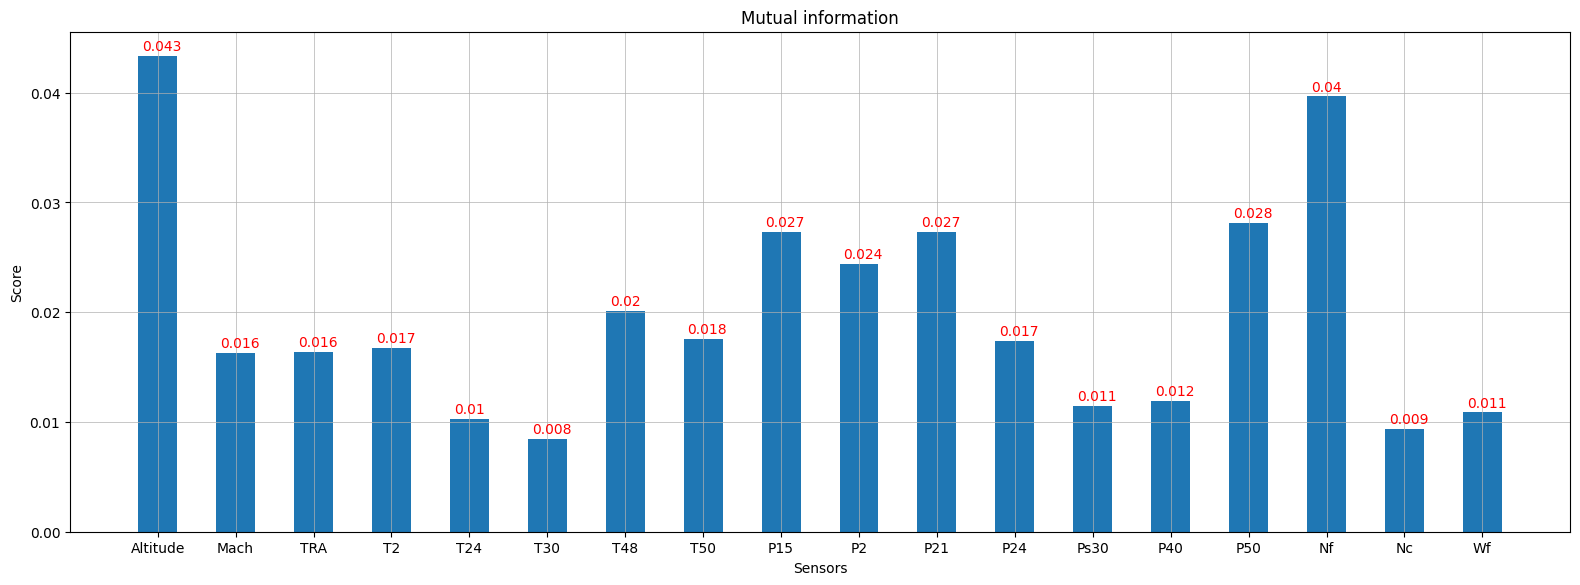

In [23]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
bars = ax.bar(X_rul.columns, mi_scores, width=0.5)
for i, v in enumerate(mi_scores):
    ax.text(i - 0.2, v + 0.0005 , str(v.round(3)), color='red')
plt.xlabel('Sensors')
plt.ylabel('Score')
plt.grid(linewidth=0.5)
plt.title('Mutual information') 
plt.show()